# Visualising Data generated by Mutation testing

In the beginning of the project, I tried to get a glimpse of the generated data by trying out different visualizations,
the most basic beeing the covariance matrix, and then two different approaches. Below you can also load other datasets.

In [1]:
%load_ext autoreload
%autoreload 2

import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import MDS
from src import visualization

In [3]:
# Load datasets
def load_dataset(filename, sparsify=False):
    mutants_and_tests = pd.read_pickle(filename)
    mutants_and_tests.reset_index()
    mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
    mutants_and_tests["outcome"]
    #display(mutants_and_tests)
    if sparsify:
        keep_fraction = 0.1 # Keep 10% of the dataset (roughly, since we delete tests and mutants smaller than that)
        max_mutant_id = mutants_and_tests['mutant_id'].max()
        max_test_id = mutants_and_tests['test_id'].max()
        return mutants_and_tests.loc[mutants_and_tests['test_id'] < max_test_id * keep_fraction].loc[mutants_and_tests['mutant_id'] < max_mutant_id * keep_fraction]
    return mutants_and_tests

datasets = {}
for name, filename in {'Flask': 'flask_full.pkl', 'Jinja': 'jinja_full.pkl', 'Httpie': 'httpie_full.pkl', 'Docopt': 'docopt_full.pkl'}.items():
    # It is possible to use the sparsify flag, if you want to test if models throw errors / for a quick check.
    # USE WITH CAUTION: This is by no means designed to give an appropriate / random sample.
    dataset = load_dataset('data/' + filename, sparsify=True) 
    datasets[name] = dataset
    

# Correlation Matrixes

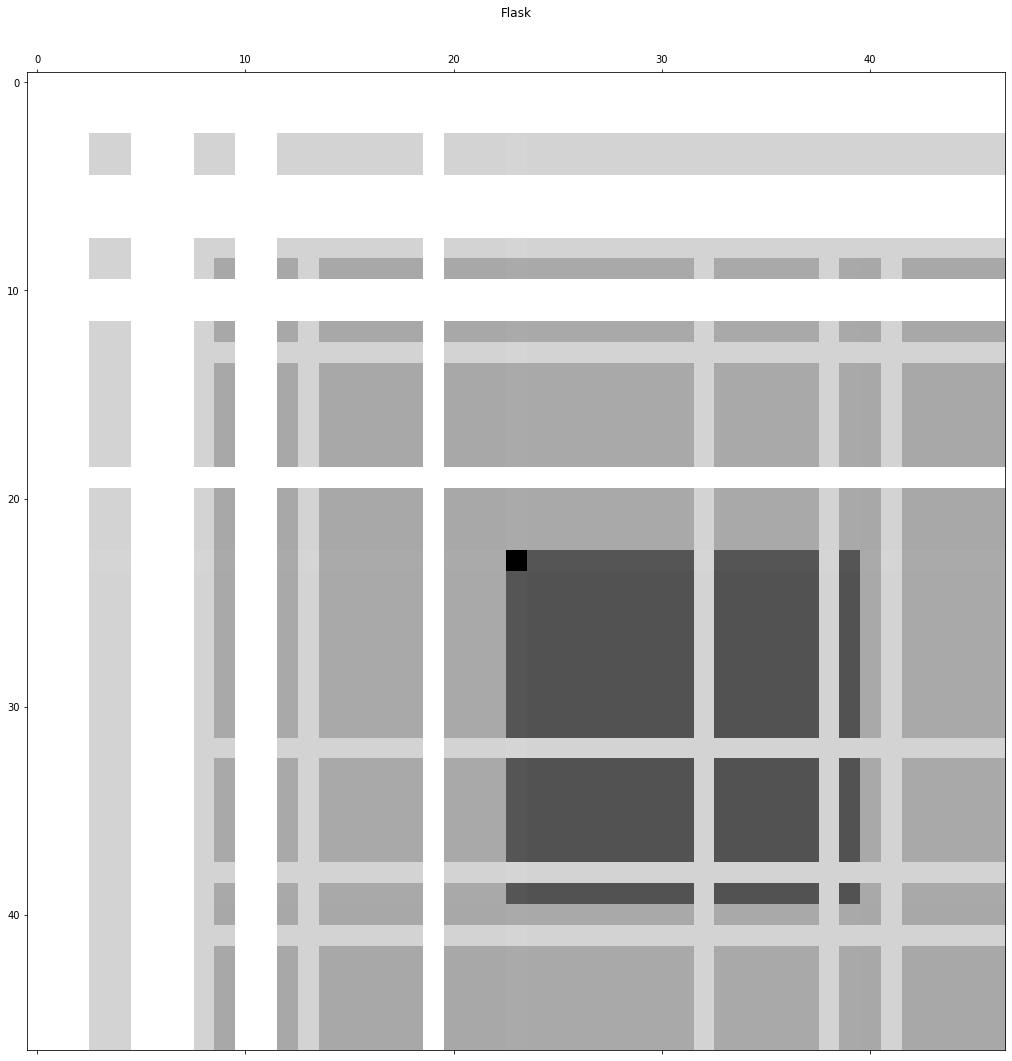

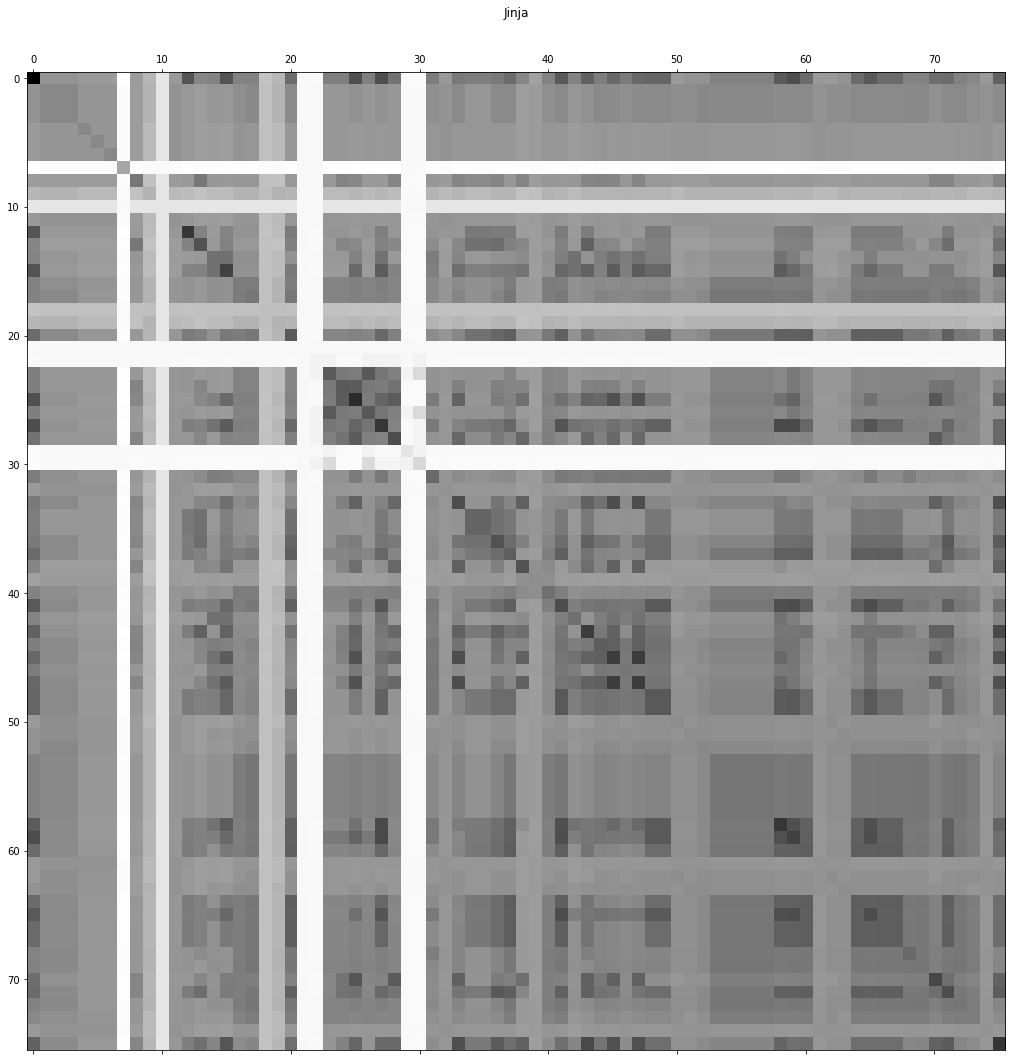

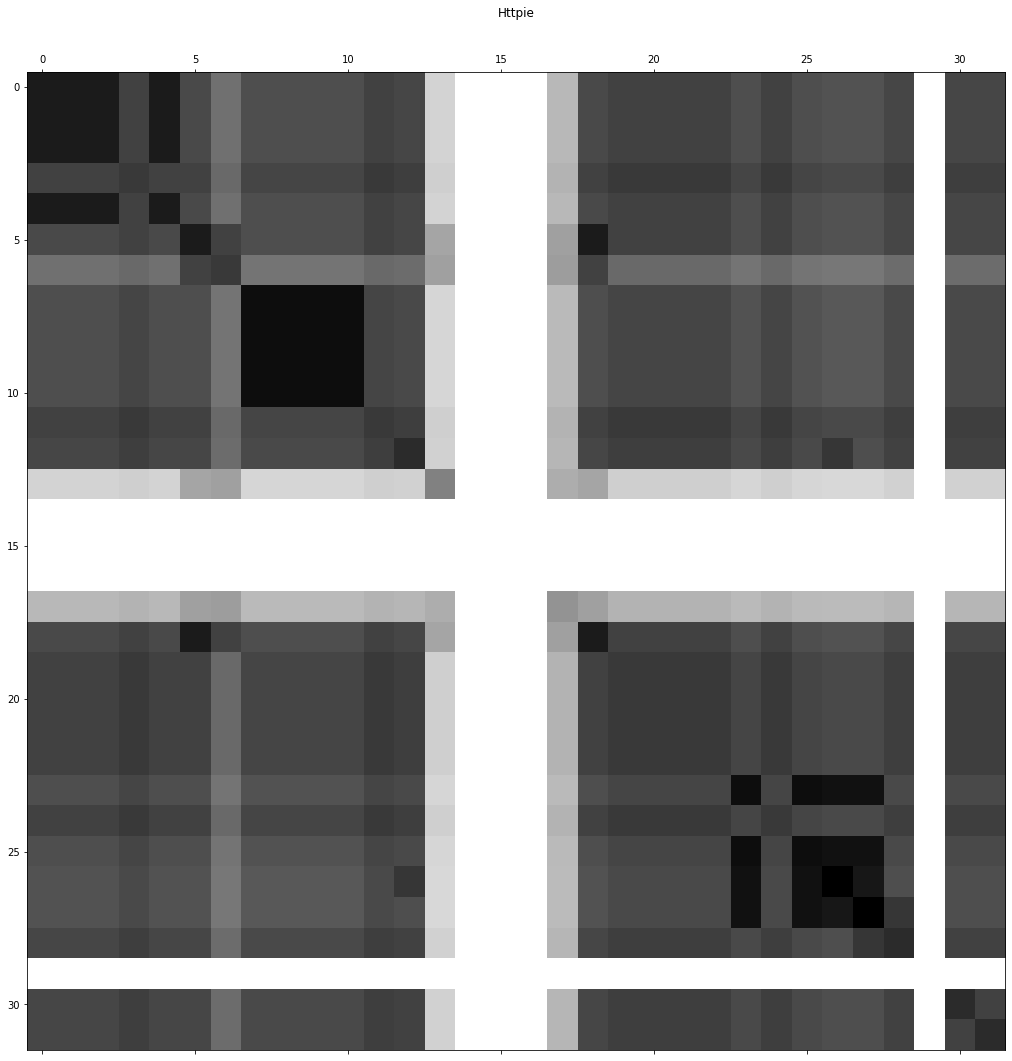

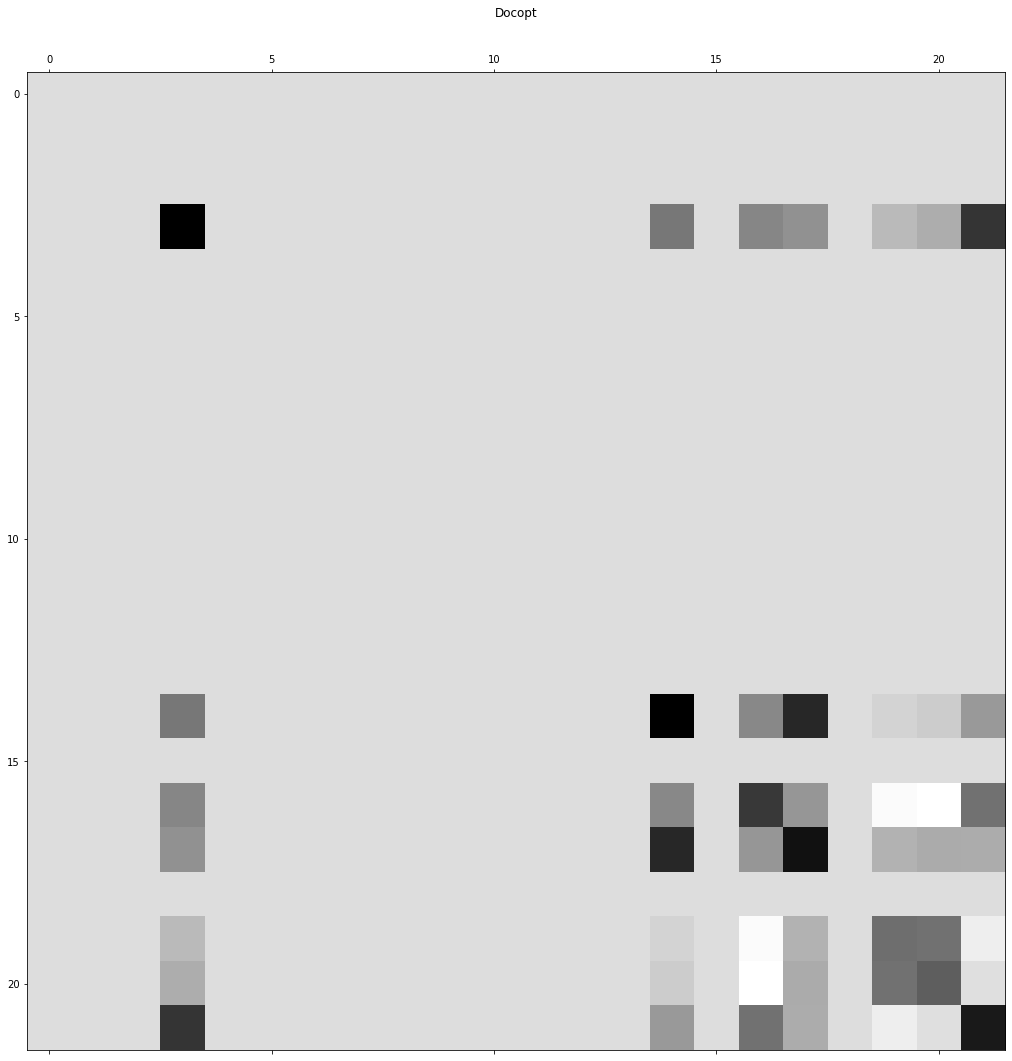

In [103]:
def plot_covariance_matrix(name, mutants_and_tests):
    pivot = mutants_and_tests.set_index('mutant_id').pivot(columns='test_id', values='outcome')
    pivot = pivot.astype('bool')
    fig, ax = plt.subplots(figsize=(18,18))
    ax.matshow(pivot.cov(), cmap=plt.get_cmap('binary'))
    #plt.axis('off')
    plt.title(name)
    plt.show()
    
for name, mutants_and_tests in datasets.items():
    plot_covariance_matrix(name, mutants_and_tests)

An interesting aspect is also how often tests fail in general, and how the distribution is through the datasets:

What we can observe is that while flask and httpie have a very low number of often failing tests, jinja and docopt have a wider variety of tests failing.
We can see the behavoior also in the covariance matrixes, that are a lot lighter for flask and httpie, due to less covariance in tests often failing together.

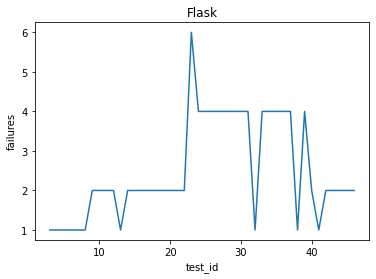

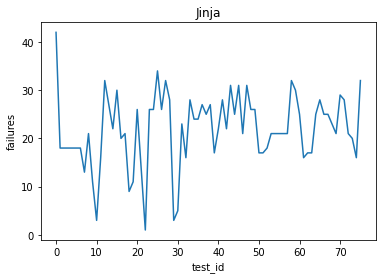

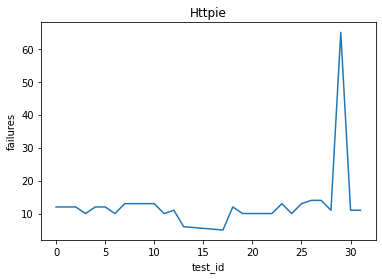

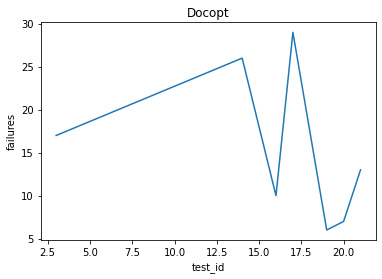

In [104]:
for name, data in datasets.items():
    plot_failure_histogram(name,data)

# Hierarchical Plot of tests


To try to get even more insight into the different datasets, I tried to come up with my own domain specific visualization, that builds on top of the failure histogram.

We print one dot for every test, with the following properties:
x axis = average of ids of changed line (mutant_ids) that make this test fail
y axis = number of mutants that make this test fail

So for example a unit test should be relatively wide down, since it should not fail on too many mutants.

To show the 'spread' of which mutant_ids made which tests fail, we draw an arrow from (mutant_id, 0) to (x,y) of the test, iff mutant_id makes the test fail

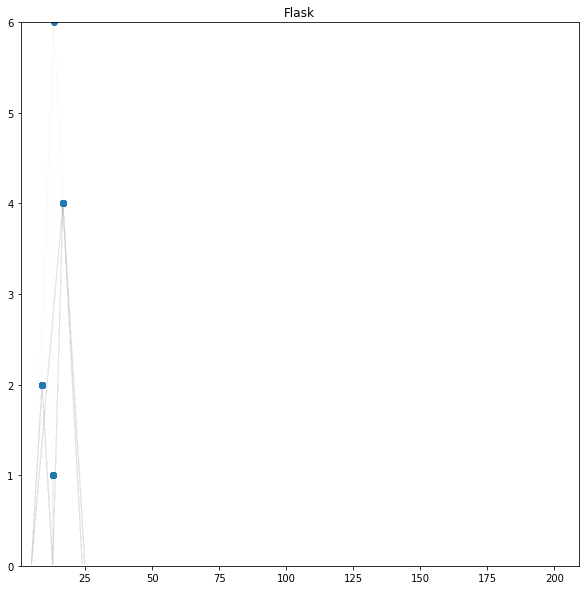

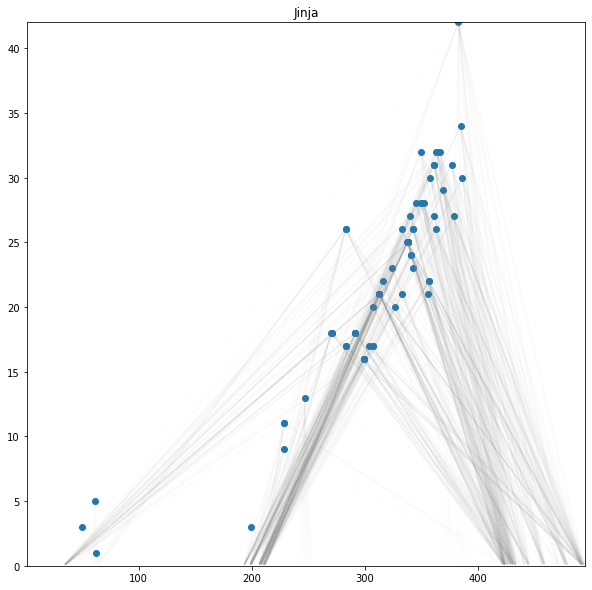

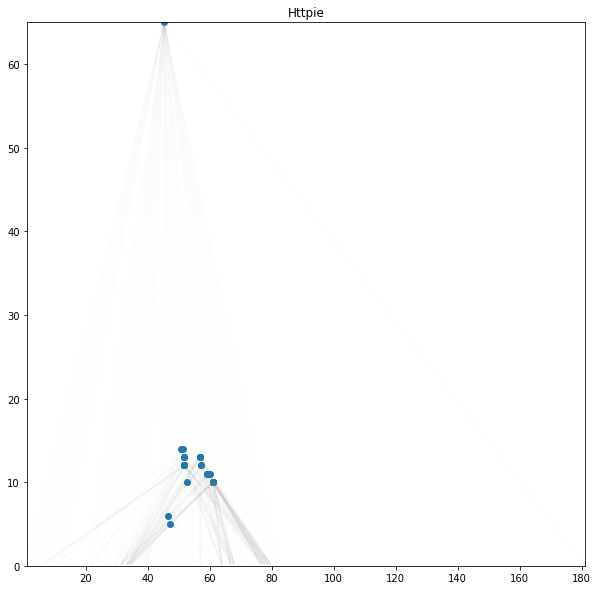

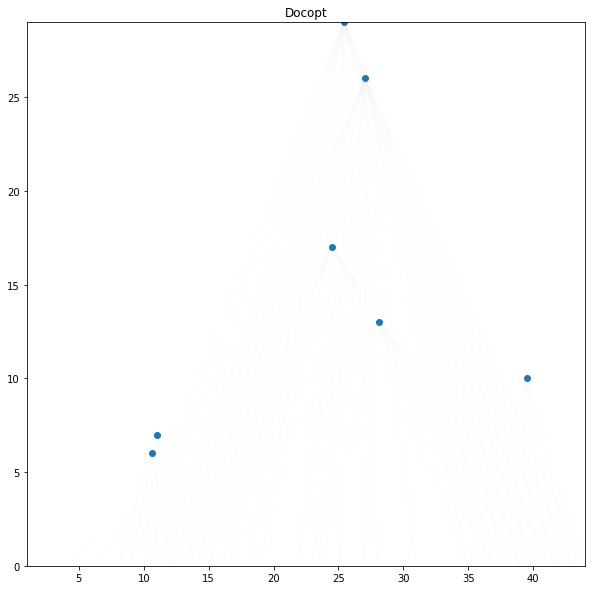

In [5]:
# For larger datasets, this may take a while (~5minutes). You can disable the arrows, then it becomes seconds
for name, mutants_and_tests in datasets.items():
    visualization.plot_hierarchical_failures(name, mutants_and_tests, arrows=True)

In [6]:
# TODO: Test duration vs failure rate to prepare for apfdc